Fundamentos de analítica 2 (trabajo final)

Alfredo Aponte, Álvaro Rodríguez

Profesor Diego Fernando Agudelo

Universidad ICESI

diegoagudelo30@gmail.com

## 0. Contexto

**Parcial final**

**Instrucciones**
El examen se compone de dos partes:
- La primera corresponde a una parte de selección múltiple con 19 preguntas que se responderán en el salón de clase en 45 minutos. Esa primera parte tiene una calificación de 1 a 5.
-La segunda parte corresponde a la parte práctica del examen y tiene también una calificación de 1 a 5.

- La nota de este examen parcial corresponderá al promedio ponderado de las dos notas, donde la parte práctica tiene un peso de 40 % y la parte de selección múltiple de 60 %.
- Usted tiene hasta el 30 de agosto a las 12:00 pm para enviar los archivos por correo, estos archivos deben tener su nombre.
- Sólo se calificaran exámenes en formato pdf. Cualquier otro formato no será tenido en cuenta.
- El examen debe estar acompañado de un notebook (ipynb)  que incluya todo los códigos de python que se emplean para obtener sus resultados.
- El nombre del archivo debe tener su nombre. No se recibirán archivos en otro formato.
- Esta parte del examen es para realizar en casa y debe reflejar el trabajo individual.

**El Problema**

En días recientes trabajamos con una compañía de comestibles que estaba interesada en predecir el comportamiento de las ventas (en unidades) de sus dos productos estrella. Fuimos contratados para generar un modelo que permita pronosticar las ventas del siguiente mes de cada uno de esos dos productos. La base de datos disponible en el archivo Examen.csv tiene la información de cada uno de los productos desde enero de 2008.

Su misión es encontrar el mejor modelo para pronosticar cada una de las series. Usted debe entregar un informe escrito de no más de cuatro páginas que presente los resultados al cliente y cuente el proceso para llegar a los pronósticos. Vea las instrucciones para asegurar que entrega los archivos requeridos.

## **1. Carga de paquetes**

In [1]:
import numpy as np
import pandas as pd # Operaciones con dataframes
from matplotlib import pyplot as plt # gráficos
from statsmodels.tsa.seasonal import seasonal_decompose # descomposición de series
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_squared_error
import optuna
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

## **2. Carga de datos**

Nuestra primera tarea será leer el archivo. Para eso podemos emplear el paquete Pandas. Carguemos los datos en un objeto que denominaremos data.

In [2]:
data = pd.read_csv("Examen.csv")
data.columns.values[0] = "corte"
data["Fecha"] = pd.date_range(start="2008-01-01", periods=len(data), freq="MS")
data["indice"] = data["corte"] - 1
data.set_index("Fecha",inplace=True)
columnas = data.columns.tolist()
columnas.remove("indice")
columnas.insert(0, "indice")
data = data[columnas]
data.head(3)

,indice,corte,producto1,producto2
Fecha,,,,
2008-01-01,0,1,4000.000000,3000.000000
2008-02-01,1,2,3997.400893,3010.686220
2008-03-01,2,3,3978.605317,3022.018584


Graficamos la series para ver su comportamiento



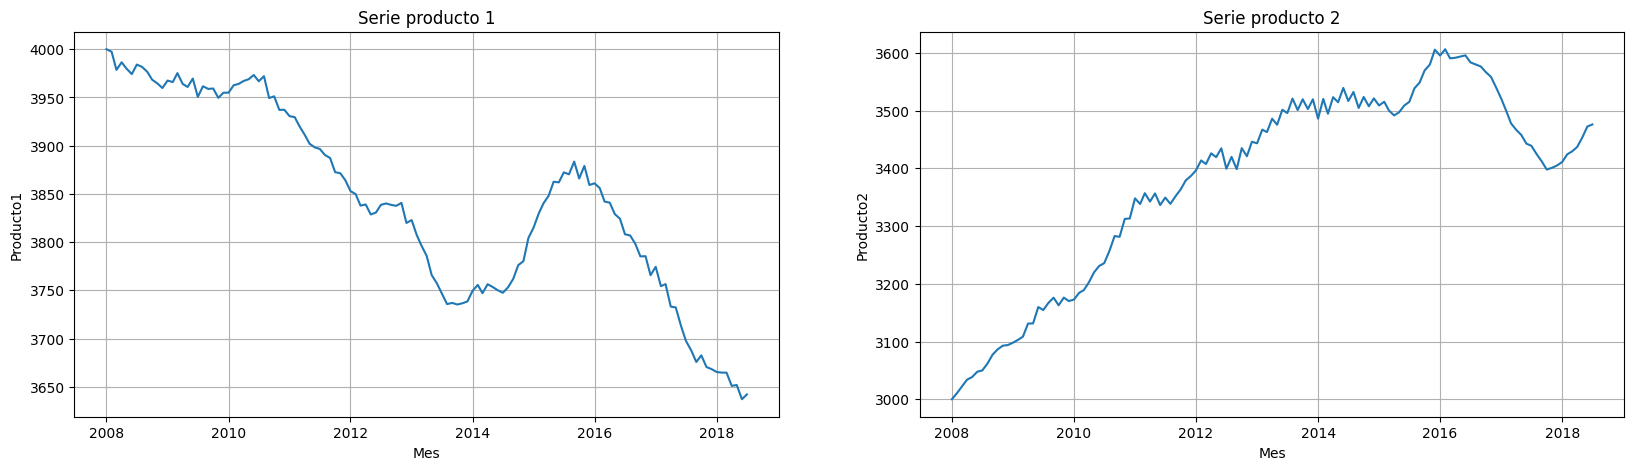

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1.set_title("Serie producto 1")
ax1.set_xlabel("Mes")
ax1.set_ylabel("Producto1")
ax1.plot(data[["producto1"]])
ax1.grid()

ax2.set_title("Serie producto 2")
ax2.set_xlabel("Mes")
ax2.set_ylabel("Producto2")
ax2.plot(data[["producto2"]])
ax2.grid()

plt.show()

## **3. Encontrando los componentes de una serie de tiempo**

En algunas ocasiones puede ser útil empezar nuestro análisis descomponiendo la serie de tiempo en sus componentes: **tendencia**, **estacionalidad** y **componente puramente aleatorio**. Una forma de hacer esto es empleando la función seasonal_decompose.

-------------------------------------------------------------Producto 1 - aditivo-------------------------------------------------------------


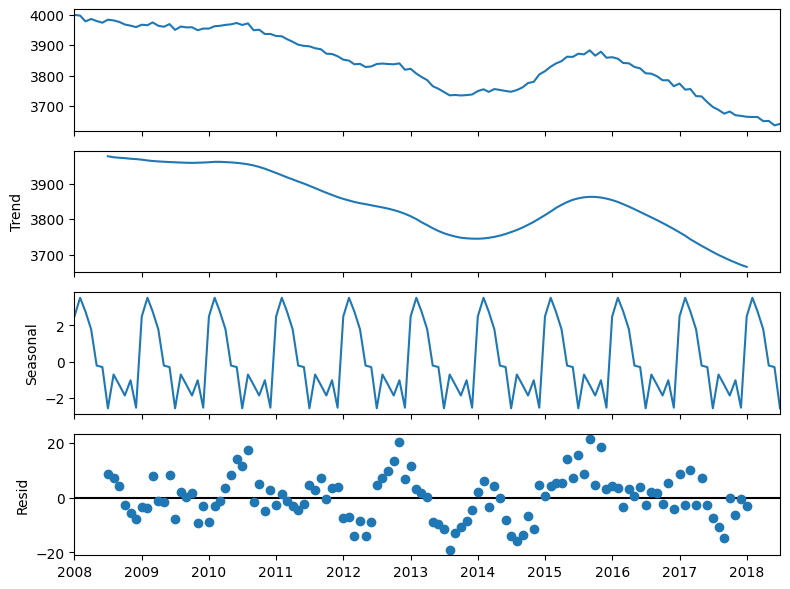

-------------------------------------------------------------Producto 1 - Multiplicativo-------------------------------------------------------------


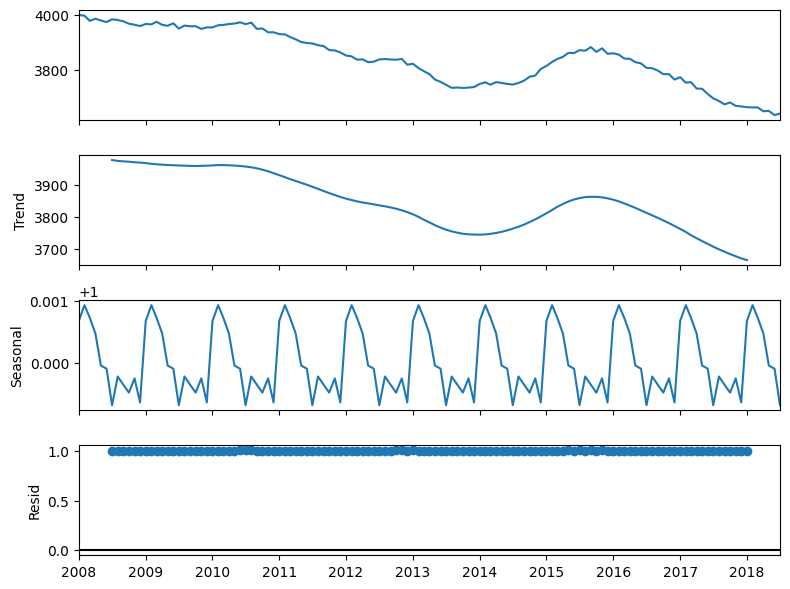

-------------------------------------------------------------Producto 2 - aditivo-------------------------------------------------------------


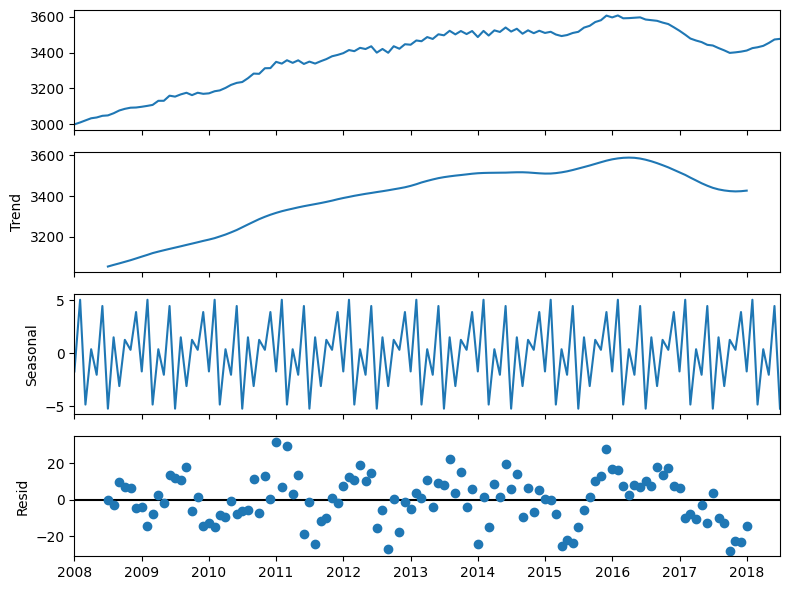

-------------------------------------------------------------Producto 2 - Multiplicativo-------------------------------------------------------------


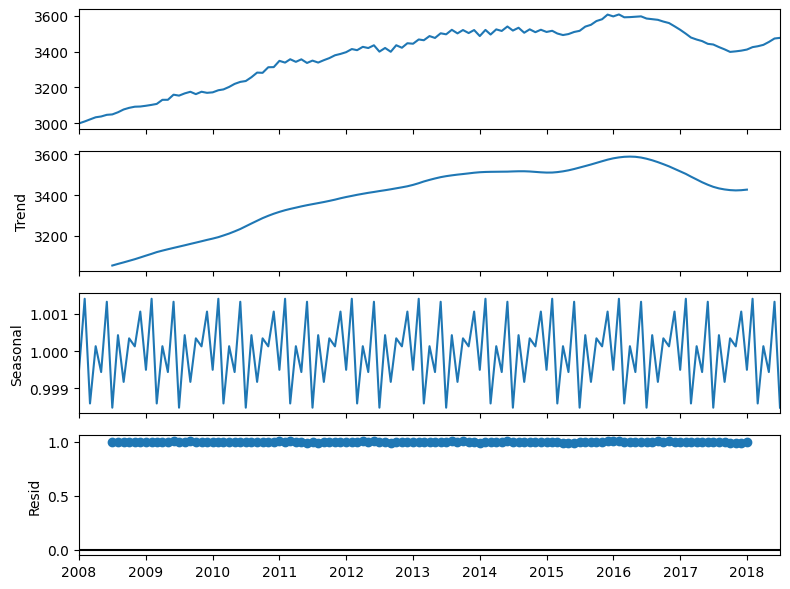

In [4]:
producto1_componentes_aditivos = seasonal_decompose(data[["producto1"]],model="additive")
fig = producto1_componentes_aditivos.plot()
fig.set_size_inches((8, 6))
fig.tight_layout()
print("-------------------------------------------------------------Producto 1 - aditivo-------------------------------------------------------------")
plt.show()

producto1_componentes_multiplicativos = seasonal_decompose(data[["producto1"]],model="multiplicative")
fig = producto1_componentes_multiplicativos.plot()
fig.set_size_inches((8, 6))
fig.tight_layout()
print("-------------------------------------------------------------Producto 1 - Multiplicativo-------------------------------------------------------------")
plt.show()

producto2_componentes_aditivos = seasonal_decompose(data[["producto2"]],model="additive")
fig = producto2_componentes_aditivos.plot()
fig.set_size_inches((8, 6))
fig.tight_layout()
print("-------------------------------------------------------------Producto 2 - aditivo-------------------------------------------------------------")
plt.show()

producto2_componentes_multiplicativos = seasonal_decompose(data[["producto2"]],model="multiplicative")
fig = producto2_componentes_multiplicativos.plot()
fig.set_size_inches((8, 6))
fig.tight_layout()
print("-------------------------------------------------------------Producto 2 - Multiplicativo-------------------------------------------------------------")
plt.show()

Podemos observar el componente estacional marcado en las series de los 2 productos, una tendencia no lineal de los datos y la parte aleatoria.

Es importante mencionar que esta descomposición se emplea **solo como referencia para iniciar el análisis**.

Para los dos productos, el gráfico que mejor se ajusta es empleando una composición "aditiva".

## **4.  Protoco de evaluación**

Se escogió para todos los modelos un protocolo de evaluación de ventana móvil, hallando la cantidad óptima de períodos (meses) de test (test_period) a través de optimización bayesiana.

Los modelos a considerar son:  
-Promedio Móvil(pm).  
-Suavización exponencial (ETS).  
-Regresión lineal (ols).  
-Arima

## **5.  Evaluación de modelos**

### **5.1 Cálculo de mejor modelo e hiperparámetros a través de optimización bayesiana**

Se aplica un protocolo de evaluación de ventana móvil y como parámetro para la optimización bayeasiana, la métrica RMSE.  A partir de 200 iteraciones se llega a un objetivo de minimización del RMSE con los mejores hiperparámetros. 

In [5]:
class ModelOptimization:
  def __init__(self, df):
    self.df_producto = df
    self.month_dummies = pd.get_dummies(self.df_producto.index.month, drop_first=True).set_index(self.df_producto.index)
    self.month_dummies = self.month_dummies.astype(float) # para arreglar el problema de casteo
    self.month_dummies = pd.concat([self.df_producto, self.month_dummies], axis=1)# Añadir las variables dummy al final del DataFrame original
    self.y_pred = self.df_producto.iloc[:0, 0] # Inicializar la serie de predicciones
###################################################################################################
##### 1. P R O M E D I O   M O V I L                                                          #####
###################################################################################################
  def fore_ma(self,datos,w,h):
    data=datos.copy()
    for x in range(1,h+1):
      ind = data.index[-1]
      value = ind + pd.DateOffset(months=1)
      data.loc[value]= data[-w:].mean()
    return data[-h:] 

  def promedio_movil(self, sample_size, test_period, window, min_periods):
      y_pred       = self.df_producto.iloc[:0, 0] 
      begin_sample =  len(self.df_producto) - sample_size
      for test_size in range(0, test_period):
          begin_train = begin_sample + test_size
          end_train   = len(self.df_producto) - test_period + test_size
          y_train     = self.df_producto.iloc[begin_train:end_train, 0]
          ma          = y_train.rolling(window,min_periods=min_periods).mean()
          ## Sin considerar el dato actual
          ma          = y_train.shift().rolling(window,min_periods=min_periods).mean()
          pred_1      = self.fore_ma(datos=y_train,w=window,h=1) # Solo se predice un periodo              
          y_pred.loc[pred_1.index[0]] = pred_1.values[0]
          
      y_test      = self.df_producto.iloc[-test_period:, 0]      
      rsme        = np.sqrt(mean_squared_error(y_test,y_pred ))
      self.y_pred = y_pred

      return rsme

  def objective_pm(self, trial):
    sample_size = trial.suggest_categorical('sample_size', set_sample_size)
    test_period = trial.suggest_categorical('test_period', set_test_period)
    window      = trial.suggest_int('window', 7, 10)
    min_periods = trial.suggest_int('min_periods', 2, 6)
    
    model = self.promedio_movil( sample_size=sample_size, test_period=test_period, window=window, min_periods=min_periods) 
    
    return model


###################################################################################################
##### 2. E T S                                                                                #####
###################################################################################################
  def calcular_ets(self, sample_size, test_period, error, trend, seasonal, alpha, beta, gamma):   
    y_pred       = self.df_producto.iloc[:0, 0] 
    begin_sample =  len(self.df_producto) - sample_size
    
    parameters = {}
    
    parameters['error'] = error
    if trend is not None:
      parameters['trend'] = trend
    if seasonal is not None:
      parameters['seasonal'] = seasonal

    params = {'smoothing_level': alpha,'smoothing_trend': beta,'smoothing_seasonal':gamma}

    if trend is None:
      params.pop('smoothing_trend')
    if seasonal is None:
      params.pop('smoothing_seasonal')
    
    for test_size in range(0, test_period):
      begin_train = begin_sample + test_size
      end_train   = len(self.df_producto) - test_period + test_size

      y_train   = self.month_dummies.iloc[begin_train:end_train]
      y_test    = self.month_dummies.iloc[end_train:]

      ets_model = ETSModel(endog=y_train.iloc[:, 0],error=error,trend=trend,seasonal=seasonal)

      ets_result = ets_model.fit_constrained(params)

      pred_1     = ets_result.forecast(1) # Solo se predice un periodo
      
      y_pred.loc[y_test.index[0]] = pred_1.values[0]

    y_test      = self.month_dummies.iloc[-test_period:]
    rsme        = np.sqrt(mean_squared_error(y_test.iloc[:, 0],y_pred))
    self.y_pred = y_pred

    return rsme
    
  def objective_ets(self, trial):
#   Error	Trend	Seasonal	Alpha	Beta	Gamma	RMSE
    sample_size = trial.suggest_categorical('sample_size', set_sample_size)
    test_period = trial.suggest_categorical('test_period', set_test_period)
    error       = trial.suggest_categorical('error', ['Add', 'Mul'])
    trend       = trial.suggest_categorical('trend', ['Add', 'Mul',None])
    seasonal    = trial.suggest_categorical('seasonal', ['Add', 'Mul',None])
    alpha       = trial.suggest_float('alpha', 0.01, 0.99)
    beta        = trial.suggest_float('beta', 0.01, 0.99)
    gamma       = trial.suggest_float('gamma', 0.01, 0.99)

    model = self.calcular_ets( sample_size=sample_size, test_period=test_period, error=error, trend=trend, seasonal=seasonal, alpha=alpha, beta=beta, gamma=gamma) 
    
    return model


###################################################################################################
##### 3. O L S                                                                                #####
###################################################################################################
  def calcular_ols(self, sample_size, test_period, estacionalidad, grado): 
    y_pred = self.df_producto.iloc[:0, 0] 
    begin_sample =  len(self.df_producto) - sample_size

    for test_size in range(0, test_period):
        begin_train = begin_sample + test_size
        end_train   = len(self.df_producto) - test_period + test_size
      
        #Dividimos el dataset en train y test
        y_train   = self.month_dummies.iloc[begin_train:end_train, 0]
        y_test    = self.month_dummies.iloc[end_train:, 0]
        
        ln_test   = np.linspace(len(y_train) + 1, len(self.df_producto), len(y_test))
        X_test    = np.vander(ln_test, N=grado+1)

        ln_train  = np.linspace(1, y_train.shape[0], y_train.shape[0])
        X_train   = np.vander(ln_train, N=grado+1)

        if estacionalidad == 'Si':        
            X_train = np.concatenate([X_train, self.month_dummies.iloc[begin_train:end_train, 3:].values], axis=1)
            X_test  = np.concatenate([X_test,  self.month_dummies.iloc[end_train:, 3:].values],  axis=1)

        lin    = sm.OLS(y_train, X_train).fit()

        pred_1 = lin.predict(X_test)
        
        y_pred.loc[y_test.index[0]] = pred_1[0]

    y_test      = self.month_dummies.iloc[-test_period:, 0]       
    rsme        = np.sqrt(mean_squared_error(y_test, y_pred))
    self.y_pred = y_pred

    return rsme
  
  def objective_ols(self, trial):
    sample_size    = trial.suggest_categorical('sample_size', set_sample_size)
    test_period    = trial.suggest_categorical('test_period', set_test_period)
    estacionalidad = trial.suggest_categorical('Estacionalidad', ['Si', 'No'])
    grado          = trial.suggest_int('grado', 2, 30)
    
    model = self.calcular_ols(sample_size=sample_size, test_period=test_period, estacionalidad=estacionalidad, grado=grado) 
    
    return model
  
###################################################################################################
##### 4. A R I M A                                                                            #####
###################################################################################################
  def calcular_arima(self, sample_size, test_period, p, d, q):
    y_pred = self.df_producto.iloc[:0,0]

    begin_sample =  len(self.df_producto) - sample_size

    for test_size in range(0, test_period):
#     train_len = len(self.df_producto) - test_period + i
      begin_train = begin_sample + test_size
      end_train   = len(self.df_producto) - test_period + test_size
      
      #Dividimos el dataset en train y test
      y_train = self.df_producto.iloc[begin_train:end_train]
      y_test  = self.df_producto.iloc[end_train:]

      # Ajusta el modelo ARIMA con los parámetros sugeridos
      model = ARIMA(y_train, order=(p, d, q))
      model_fit = model.fit()
    
      # Realiza predicciones en el conjunto de prueba
      pred_1 = model_fit.predict(start=len(y_train), end=len(y_train) + 1, dynamic=False)

      y_pred.loc[y_test.index[0]] = pred_1.values[0]
    
    y_test      = self.df_producto.iloc[-test_period:]
    rsme        = np.sqrt(mean_squared_error(y_test, y_pred))
    self.y_pred = y_pred

    return rsme

  def objective_arima(self, trial):
    sample_size = trial.suggest_categorical('sample_size', set_sample_size)
    test_period = trial.suggest_categorical('test_period', set_test_period)
    p           = trial.suggest_int('p', 0, 3)  # Orden autorregresivo
    d           = trial.suggest_int('d', 0, 3)  # Orden de diferenciación
    q           = trial.suggest_int('q', 0, 3)  # Orden de media móvil
    model = self.calcular_arima(sample_size=sample_size, test_period=test_period,p=p, d=d, q=q)
    
    return model


In [6]:
column_names = data.columns.tolist()
column_names.remove('indice')
column_names.remove('corte')
print(column_names)

global set_sample_size
global set_test_period

['producto1', 'producto2']


Como el modelo se va a ejecutar varias veces, por optimizacion de codigo define como una funcion para que peuda ser referenciada y no escribir multiples veces el mismo codigo.

En este se recorre para cada producto, la optimizacion bayesiana de:
- Promedio Movil
- ETS
- OLS
- Arima

los mejores resultados para cada modelo se almacenan en un dataframe que será utilizado en pasos posteriores

In [7]:

def run_model(trials): 
    global set_sample_size
    global set_test_period
    global  df_products
    
    results = []

    for producto in column_names:

        product_row = df_products[df_products['producto'] == producto]

        if not product_row.empty:
            best_params     = product_row.iloc[0]['best_params']
            set_sample_size = [best_params['sample_size']]
            set_test_period = [best_params['test_period']]            
        else:
            set_sample_size = global_size
            set_test_period = global_period

        model_optimization = ModelOptimization(data[[producto]])

        study_pm = optuna.create_study(direction='minimize')
        study_pm.optimize(model_optimization.objective_pm, n_trials=trials)
        results.append({
        'producto': producto,
        'tipo': 'Promedio movil',
        'rmse': study_pm.best_value,
        'best_params': study_pm.best_params })

        study_ets = optuna.create_study(direction='minimize')
        study_ets.optimize(model_optimization.objective_ets, n_trials=trials)
        results.append({
        'producto': producto,
        'tipo': 'ETS',
        'rmse': study_ets.best_value,
        'best_params': study_ets.best_params })

        study_ols = optuna.create_study(direction='minimize')
        study_ols.optimize(model_optimization.objective_ols, n_trials=trials)
        results.append({
        'producto': producto,
        'tipo': 'OLS',
        'rmse': study_ols.best_value,
        'best_params': study_ols.best_params })

        study_arima = optuna.create_study(direction='minimize')
        study_arima.optimize(model_optimization.objective_arima, n_trials=trials)
        results.append({
        'producto': producto,
        'tipo': 'ARIMA',
        'rmse': study_arima.best_value,
        'best_params': study_arima.best_params })
        
        print("------------------------------------------------------------------")    
    
    df_results = pd.DataFrame(results, columns=['producto', 'tipo', 'rmse', 'best_params'])
    df_results.sort_values(by=['producto', 'rmse'], ascending=[True, True],inplace=True)
        
    for index, row in df_results.iterrows():
        print(f"Producto: {row['producto']}")
        print(f"Tipo: {row['tipo']}")
        print(f"RMSE: {row['rmse']}")
        print(f"Best Params: {row['best_params']}")
        print("--------------------------------------------------")
    
    return df_results

Se ejecuta el modelo para identificar los 2 primeros hiperparametros, Tamaño de la ventana (T), desde donde vamos obtener el T-H (In-sample) y H (Out-Sample)

Se establecen como opciones para T de 48 períodos (4 años), 72 períodos (6 años), 96 períodos (8 años)  y 127 (Muestra completa)

En relacion a los datos de Out_Sample que se van a utilizar para test, se manejan parámetros de 6 meses, 12 meses, 18 meses y 24 meses, con estos valores se realizan las diferentes validaciones del modelo 

Se establece 200 muestras para realizar las ejecuciones de optimización bayesiana

In [8]:
global_size   = [48, 72, 96, 127]
global_period = [6, 12, 18, 24]
trials        = 200
df_products = pd.DataFrame(columns=['producto', 'tipo', 'rmse', 'best_params'])

df_results    = run_model(trials)


[I 2024-09-17 11:13:03,756] A new study created in memory with name: no-name-8509aba1-37cb-44ac-9750-c45d3b4751c8
[I 2024-09-17 11:13:03,972] Trial 0 finished with value: 36.02731366835366 and parameters: {'sample_size': 96, 'test_period': 24, 'window': 8, 'min_periods': 6}. Best is trial 0 with value: 36.02731366835366.
[I 2024-09-17 11:13:04,025] Trial 1 finished with value: 36.40560075214798 and parameters: {'sample_size': 48, 'test_period': 12, 'window': 9, 'min_periods': 4}. Best is trial 0 with value: 36.02731366835366.
[I 2024-09-17 11:13:04,118] Trial 2 finished with value: 36.17612478383117 and parameters: {'sample_size': 96, 'test_period': 18, 'window': 8, 'min_periods': 4}. Best is trial 0 with value: 36.02731366835366.
[I 2024-09-17 11:13:04,169] Trial 3 finished with value: 25.429264297321534 and parameters: {'sample_size': 127, 'test_period': 6, 'window': 10, 'min_periods': 5}. Best is trial 3 with value: 25.429264297321534.
[I 2024-09-17 11:13:04,332] Trial 4 finished wi

------------------------------------------------------------------


[I 2024-09-17 11:19:27,235] Trial 4 finished with value: 55.41471244323816 and parameters: {'sample_size': 96, 'test_period': 18, 'window': 9, 'min_periods': 5}. Best is trial 0 with value: 34.40391778291415.
[I 2024-09-17 11:19:27,281] Trial 5 finished with value: 43.41819610164074 and parameters: {'sample_size': 127, 'test_period': 12, 'window': 9, 'min_periods': 2}. Best is trial 0 with value: 34.40391778291415.
[I 2024-09-17 11:19:27,302] Trial 6 finished with value: 35.082193464942094 and parameters: {'sample_size': 96, 'test_period': 6, 'window': 9, 'min_periods': 2}. Best is trial 0 with value: 34.40391778291415.
[I 2024-09-17 11:19:27,325] Trial 7 finished with value: 34.40391778291415 and parameters: {'sample_size': 127, 'test_period': 6, 'window': 10, 'min_periods': 4}. Best is trial 0 with value: 34.40391778291415.
[I 2024-09-17 11:19:27,384] Trial 8 finished with value: 50.858145166281 and parameters: {'sample_size': 96, 'test_period': 18, 'window': 8, 'min_periods': 5}. Be

------------------------------------------------------------------
Producto: producto1
Tipo: ETS
RMSE: 5.407414813535559
Best Params: {'sample_size': 96, 'test_period': 6, 'error': 'Add', 'trend': None, 'seasonal': 'Mul', 'alpha': 0.7558186286611535, 'beta': 0.0918466590467808, 'gamma': 0.33754452507352734}
--------------------------------------------------
Producto: producto1
Tipo: ARIMA
RMSE: 5.438842329971916
Best Params: {'sample_size': 48, 'test_period': 6, 'p': 3, 'd': 1, 'q': 3}
--------------------------------------------------
Producto: producto1
Tipo: OLS
RMSE: 5.694295696809006
Best Params: {'sample_size': 48, 'test_period': 6, 'Estacionalidad': 'Si', 'grado': 4}
--------------------------------------------------
Producto: producto1
Tipo: Promedio movil
RMSE: 17.011191792920002
Best Params: {'sample_size': 96, 'test_period': 6, 'window': 7, 'min_periods': 5}
--------------------------------------------------
Producto: producto2
Tipo: ETS
RMSE: 7.197986716771442
Best Params: 

Se listan los resultados obtenidos para cada producto y tipo de modelo. Se muestra el RMSE y los mejores parámetros obtenidos para cada modelo.

In [9]:

for index, row in df_results.iterrows():
    print(f"Producto: {row['producto']}")
    print(f"Tipo: {row['tipo']}")
    print(f"RMSE: {row['rmse']}")
    print(f"Best Params: {row['best_params']}")
    print("--------------------------------------------------")

Producto: producto1
Tipo: ETS
RMSE: 5.407414813535559
Best Params: {'sample_size': 96, 'test_period': 6, 'error': 'Add', 'trend': None, 'seasonal': 'Mul', 'alpha': 0.7558186286611535, 'beta': 0.0918466590467808, 'gamma': 0.33754452507352734}
--------------------------------------------------
Producto: producto1
Tipo: ARIMA
RMSE: 5.438842329971916
Best Params: {'sample_size': 48, 'test_period': 6, 'p': 3, 'd': 1, 'q': 3}
--------------------------------------------------
Producto: producto1
Tipo: OLS
RMSE: 5.694295696809006
Best Params: {'sample_size': 48, 'test_period': 6, 'Estacionalidad': 'Si', 'grado': 4}
--------------------------------------------------
Producto: producto1
Tipo: Promedio movil
RMSE: 17.011191792920002
Best Params: {'sample_size': 96, 'test_period': 6, 'window': 7, 'min_periods': 5}
--------------------------------------------------
Producto: producto2
Tipo: ETS
RMSE: 7.197986716771442
Best Params: {'sample_size': 127, 'test_period': 24, 'error': 'Add', 'trend': 'A

Se filtra el DataFrame para conservar solo una entrada para cada producto con el menor RMSE para seleccionar dentro de la evaluacion los mejores parametros para T y T-H

In [10]:
df_products = df_results.loc[df_results.groupby('producto')['rmse'].idxmin()]


Con los valores ya fijos para cada producto, se procede a ejecutar el modelo de nuevo, para evaluar todos los modelos con el mismo criterio de T y T-H, de esta manera se evaluan los modelos en igualdad de condiciones

El modelo se ejecuta con un trial de 200, para realizar el analisis bayesiano e identificar los hiperparametros para los mejores RSME/Modelo 

In [11]:
trials  = 200

df_results = run_model(trials)


[I 2024-09-17 12:47:00,420] A new study created in memory with name: no-name-a9a436c1-8a78-4603-bbbc-0f6ba8e1118d
[I 2024-09-17 12:47:00,442] Trial 0 finished with value: 19.360260719899816 and parameters: {'sample_size': 96, 'test_period': 6, 'window': 8, 'min_periods': 3}. Best is trial 0 with value: 19.360260719899816.


[I 2024-09-17 12:47:00,465] Trial 1 finished with value: 19.360260719899816 and parameters: {'sample_size': 96, 'test_period': 6, 'window': 8, 'min_periods': 5}. Best is trial 0 with value: 19.360260719899816.
[I 2024-09-17 12:47:00,487] Trial 2 finished with value: 22.212287548155793 and parameters: {'sample_size': 96, 'test_period': 6, 'window': 9, 'min_periods': 2}. Best is trial 0 with value: 19.360260719899816.
[I 2024-09-17 12:47:00,512] Trial 3 finished with value: 25.429264297321534 and parameters: {'sample_size': 96, 'test_period': 6, 'window': 10, 'min_periods': 3}. Best is trial 0 with value: 19.360260719899816.
[I 2024-09-17 12:47:00,532] Trial 4 finished with value: 25.429264297321534 and parameters: {'sample_size': 96, 'test_period': 6, 'window': 10, 'min_periods': 2}. Best is trial 0 with value: 19.360260719899816.
[I 2024-09-17 12:47:00,557] Trial 5 finished with value: 17.011191792920002 and parameters: {'sample_size': 96, 'test_period': 6, 'window': 7, 'min_periods': 

------------------------------------------------------------------


[I 2024-09-17 13:38:49,540] Trial 5 finished with value: 42.67709837496923 and parameters: {'sample_size': 127, 'test_period': 24, 'window': 7, 'min_periods': 6}. Best is trial 1 with value: 42.67709837496923.
[I 2024-09-17 13:38:49,597] Trial 6 finished with value: 42.67709837496923 and parameters: {'sample_size': 127, 'test_period': 24, 'window': 7, 'min_periods': 3}. Best is trial 1 with value: 42.67709837496923.
[I 2024-09-17 13:38:49,649] Trial 7 finished with value: 42.67709837496923 and parameters: {'sample_size': 127, 'test_period': 24, 'window': 7, 'min_periods': 5}. Best is trial 1 with value: 42.67709837496923.
[I 2024-09-17 13:38:49,708] Trial 8 finished with value: 54.424057347761845 and parameters: {'sample_size': 127, 'test_period': 24, 'window': 10, 'min_periods': 4}. Best is trial 1 with value: 42.67709837496923.
[I 2024-09-17 13:38:49,765] Trial 9 finished with value: 50.78363432003333 and parameters: {'sample_size': 127, 'test_period': 24, 'window': 9, 'min_periods':

------------------------------------------------------------------
Producto: producto1
Tipo: ETS
RMSE: 5.080119092296547
Best Params: {'sample_size': 96, 'test_period': 6, 'error': 'Add', 'trend': 'Mul', 'seasonal': 'Mul', 'alpha': 0.3614721738156278, 'beta': 0.010663224340918544, 'gamma': 0.28139065996817625}
--------------------------------------------------
Producto: producto1
Tipo: ARIMA
RMSE: 5.5545702607327385
Best Params: {'sample_size': 96, 'test_period': 6, 'p': 3, 'd': 3, 'q': 3}
--------------------------------------------------
Producto: producto1
Tipo: Promedio movil
RMSE: 17.011191792920002
Best Params: {'sample_size': 96, 'test_period': 6, 'window': 7, 'min_periods': 4}
--------------------------------------------------
Producto: producto1
Tipo: OLS
RMSE: 17.469130441686975
Best Params: {'sample_size': 96, 'test_period': 6, 'Estacionalidad': 'Si', 'grado': 7}
--------------------------------------------------
Producto: producto2
Tipo: ETS
RMSE: 7.189164614410106
Best Par

Se listan los hiperparametros y el modelo seleccionado para el mejor RSME,  

In [12]:
df_results = df_results.loc[df_results.groupby('producto')['rmse'].idxmin()]
for index, row in df_results.iterrows():
    print(f"Producto: {row['producto']}")
    print(f"Tipo: {row['tipo']}")
    print(f"RMSE: {row['rmse']}")
    print(f"Best Params: {row['best_params']}")
    print("--------------------------------------------------")

Producto: producto1
Tipo: ETS
RMSE: 5.080119092296547
Best Params: {'sample_size': 96, 'test_period': 6, 'error': 'Add', 'trend': 'Mul', 'seasonal': 'Mul', 'alpha': 0.3614721738156278, 'beta': 0.010663224340918544, 'gamma': 0.28139065996817625}
--------------------------------------------------
Producto: producto2
Tipo: ETS
RMSE: 7.189164614410106
Best Params: {'sample_size': 127, 'test_period': 24, 'error': 'Add', 'trend': 'Mul', 'seasonal': None, 'alpha': 0.971673646631525, 'beta': 0.6846305207518105, 'gamma': 0.6450245265667924}
--------------------------------------------------


In [13]:
# Se agrega un periodo adicional para el cual se estarán realizando las predicciones
ind = data.index[-1]
value = ind + pd.DateOffset(months=1)
data.loc[value]= 0

Se realiza la predicción de 1 período, para el modelo seleccionado considerando los hiperparametros ya calculados, para cada producto se determina un modelo e hiperpaametros propios, lo que nos lleva a iterar y mostrar los valores para cada caso. 

In [1]:
for index, row in df_results.iterrows():
    producto     = row['producto']
    tipo         = row['tipo']
    best_params  = row['best_params']
    sample_size  = best_params['sample_size']
        
    model_optimization = ModelOptimization(data[[producto]])
    
    if tipo == 'Promedio movil':
        test_period = 1 # best_params['test_period']
        window      = best_params['window']
        min_periods = best_params['min_periods']
        rmse = model_optimization.promedio_movil(sample_size=sample_size, test_period=test_period, window=window, min_periods=min_periods)
    
    elif tipo == 'ETS':
        test_period = 1 #best_params['test_period']
        error       = best_params['error']
        trend       = best_params['trend']
        seasonal    = best_params['seasonal']
        alpha       = best_params['alpha']
        beta        = best_params['beta']
        gamma       = best_params['gamma']
        rmse = model_optimization.calcular_ets(sample_size=sample_size, test_period=test_period, error=error, trend=trend, seasonal=seasonal, alpha=alpha, beta=beta, gamma=gamma)
    
    elif tipo == 'OLS':
        test_period    = 1 #best_params['test_period']
        estacionalidad = best_params['Estacionalidad']
        grado          = best_params['grado']
        rmse = model_optimization.calcular_ols(sample_size=sample_size, test_period=test_period, estacionalidad=estacionalidad, grado=grado)
    
    elif tipo == 'ARIMA':
        test_period = 1 #best_params['test_period']
        p           = best_params['p']
        d           = best_params['d']
        q           = best_params['q']
        rmse = model_optimization.calcular_arima(sample_size=sample_size, test_period=test_period, p=p, d=d, q=q)
    
    print(f"Con los mejores parámetros para el producto: {producto}:")
    print(f"Modelo: {tipo}")
    print(f"Parámetros: {best_params}")
    for date, value in model_optimization.y_pred.items():
        fecha = date.date()
#       hora = date.time()
        print(f"Predicción para {fecha} de: {value}")
    print("--------------------------------------------------")

NameError: name 'df_results' is not defined

### **5.2 Escogencia del mejor modelo**

#### **5.2.1 Producto 1**

Los resultados de optimización bayesiana para el parámetro RMSE de los modelos probados son los siguientes: 

Optimización para el producto: producto1  
Mejor RMSE para promedio móvil: 8.554295238759712  
Mejor RMSE para ETS: 5.308537484864874  
Mejor RMSE para OLS: 33.51442929548304  
Mejor RMSE para ARIMA: 5.967434579717731  
Mejores parámetros para promedio móvil: {'test_period': 6, 'window': 9, 'min_periods': 2}  
Mejores parámetros para ETS: {'test_period': 6, 'error': 'Mul', 'trend': None, 'seasonal': 'Add', 'alpha': 0.  6159281128631826, 'beta': 0.15108536441364648, 'gamma': 0.48225875023126147}  
Mejores parámetros para OLS: {'test_period': 12, 'Estacionalidad': 'No', 'grado': 6}  
Mejores parámetros para ARIMA: {'test_period': 6, 'p': 3, 'd': 1, 'q': 2}   


Según los resultados anteriores, el mejor modelo es ETS con las siguientes características:  
Mejor RMSE para ETS: 5.308537484864874  
Mejores parámetros para ETS: {'test_period': 6, 'error': 'Mul', 'trend': None, 'seasonal': 'Add', 'alpha': 0.  6159281128631826, 'beta': 0.15108536441364648, 'gamma': 0.48225875023126147}  


#### **5.2.2 Producto 2**

Los resultados de optimización bayesiana para el parámetro RMSE de los modelos probados son los siguientes:  

Optimización para el producto: producto2  
Mejor RMSE para promedio móvil: 221.24582896066335  
Mejor RMSE para ETS: 7.1900793456018945  
Mejor RMSE para OLS: 31.228670865440034  
Mejor RMSE para ARIMA: 8.69716307430175  
Mejores parámetros para promedio móvil: {'test_period': 6, 'window': 7, 'min_periods': 2}  
Mejores parámetros para ETS: {'test_period': 24, 'error': 'Mul', 'trend': 'Mul', 'seasonal': None, 'alpha': 0.9892178225728151, 'beta': 0.6864931912226244, 'gamma': 0.8335838425155936}  
Mejores parámetros para OLS: {'test_period': 6, 'Estacionalidad': 'No', 'grado': 2}  
Mejores parámetros para ARIMA: {'test_period': 18, 'p': 2, 'd': 1, 'q': 0}  

Según los resultados anteriores, el mejor modelo es ETS con las siguientes características:  
Mejor RMSE para ETS: 7.1900793456018945  
Mejores parámetros para ETS: {'test_period': 24, 'error': 'Mul', 'trend': 'Mul', 'seasonal': None, 'alpha': 0.9892178225728151, 'beta': 0.6864931912226244, 'gamma': 0.8335838425155936}  

### **5.3  Validación de supuestos**

#### **5.3.1 Producto 1**

Dado que el mejor modelo es ETS, no es necesario validar supuestos

#### **5.3.2 Producto 2**

Dado que el mejor modelo es ETS, no es necesario validar supuestos

## **6.  Pronosticos**

### **6.1  Producto 1 (se ajusta el mejor modelo final completo con los mejores hiperparámetros)**



### **6.2  Producto 2**


## **7.  Conclusiones**
